# Lab Assignment Seven: Recurrent Network Architectures
 

#### Everett Cienkus, Blake Miller, Colin Weil

## 1. Preparation

### 1.1 Define and Prepare Class Variables
Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os

df = pd.read_csv('tweet_sentiments/sentiment_tweets3.csv') # read in the csv file
X = df['message to examine']
y = df['label (depression result)']

#display
display(df.head())


,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [2]:
%%time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_TWEET_LEN = 280 # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS)) + 1 
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_TWEET_LEN)

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)
print(np.max(X))

Found 23195 unique tokens. Distilled to 23196 top words.
Shape of data tensor: (10314, 280)
Shape of label tensor: (10314,)
23195
Wall time: 431 ms


The final dataset, after preparation, is set up where each word is converted to an integer and each article is a series of integers that represent the correct ordering of words.

This was accomplished by using the Keras Tokenizer as well as the Keras pad_sequences function.
We decided on a max length of 280 characters because that is the maximum length a tweet can be.

There was no need to prepare the y data because it is a binary classification that is already represented by a 0 or 1 from the csv file.

### 1.2 Choose Metric for Evaluating Peformance
Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

We are going to choose recall as our metric for evaluating performance. We are doing this because we want to minimize false negatives which would classifying someone that has depression, as not having depression. 

Our business case for identifying depression from Tweets would come from the point of view of Twitter. Although we could not directly refer a person to a doctor after classifying them as having depression (because this would be a breach of privacy/ data), we could still use this information to help our users. We could send them depression therapy ads or ads that would talk about improving mental health with the hope that they would click on them and get help. It would be super important to not miss anoyone that may be depressed because we want to help all of the users possible that would have depression. 

On the other hand, a false positive isn't that big of a deal. In this case, a user that doesn't have depression will start to receive the mental health ads. This doesn't really make a difference in their lives and they will continue scrolling through the app without even noticing the ad.

Because of these reasons, recall will be our metric for evaluating performance.

### 1.3 Choose Method for Dividing Data
Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice. 

In [3]:
# # Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Since our dataset is over 10,000, it is okay to use 80/20 split according to the Larson Rule. This allows the data to be less biased, allowing the algorithm to train with a diverse dataset. The 80/20 rule works in this case bacause the large data set almost garentees that there will be diverse data because the set should contain multiple different combinations of data. Although we are right on the cusp of having enough data, this should be okay for our model.

## 2. Modeling

### 2.1 Investigate Two Different Network Architectures
Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Alternatively, you may also choose one recurrent network and one convolutional network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust hyper-parameters of the networks as needed to improve generalization performance (train a total of at least four models). Discuss the performance of each network and compare them.

In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, SimpleRNN
from tensorflow.keras.layers import Embedding

EMBED_SIZE = 50
NUM_CLASSES = 1

input_holder = Input(shape=(X_train.shape[1], ))
shared_embed = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_TWEET_LEN)(input_holder) # number of words in each sequence

#### 2.1.1 LSTM

In [5]:
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import Recall

RNN_STATESIZE = 20
EPOCHS = 5
DROPOUT = 0.1
# create LSTM
x = LSTM(RNN_STATESIZE, dropout=DROPOUT, recurrent_dropout=DROPOUT)(shared_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
lstm_model = Model(inputs=input_holder,outputs=x)
lstm_model.compile(loss='binary_crossentropy', 
              optimizer= 'adam', 
              metrics=['accuracy',tf.keras.metrics.Recall()])

In [6]:
lstm_history = lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
129/129 [==============================] - 71s 524ms/step - loss: 0.3845 - accuracy: 0.8354 - recall: 0.2963 - val_loss: 0.1337 - val_accuracy: 0.9554 - val_recall: 0.8182
Epoch 2/5
129/129 [==============================] - 53s 411ms/step - loss: 0.0504 - accuracy: 0.9916 - recall: 0.9694 - val_loss: 0.0301 - val_accuracy: 0.9976 - val_recall: 0.9911
Epoch 3/5
129/129 [==============================] - 45s 350ms/step - loss: 0.0139 - accuracy: 0.9989 - recall: 0.9957 - val_loss: 0.0183 - val_accuracy: 0.9976 - val_recall: 0.9911
Epoch 4/5
129/129 [==============================] - 45s 351ms/step - loss: 0.0072 - accuracy: 0.9994 - recall: 0.9973 - val_loss: 0.0154 - val_accuracy: 0.9976 - val_recall: 0.9911
Epoch 5/5
129/129 [==============================] - 45s 351ms/step - loss: 0.0100 - accuracy: 0.9979 - recall: 0.9941 - val_loss: 0.0391 - val_accuracy: 0.9869 - val_recall: 0.9911


In [7]:
RNN_STATESIZE = 40
DROPOUT = 0.2

shared_embed = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_TWEET_LEN)(input_holder) # number of words in each sequence

# create LSTM with modified parameters
x = LSTM(RNN_STATESIZE, dropout=DROPOUT, recurrent_dropout=DROPOUT)(shared_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
lstm_model2 = Model(inputs=input_holder,outputs=x)
lstm_model2.compile(loss='binary_crossentropy', 
              optimizer= 'adam', 
              metrics=['accuracy',tf.keras.metrics.Recall()])

In [8]:
lstm_history2 = lstm_model2.fit(X_train, y_train, epochs=EPOCHS, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
129/129 [==============================] - 56s 414ms/step - loss: 0.3463 - accuracy: 0.8567 - recall_1: 0.3843 - val_loss: 0.1081 - val_accuracy: 0.9714 - val_recall_1: 0.9667
Epoch 2/5
129/129 [==============================] - 53s 413ms/step - loss: 0.0294 - accuracy: 0.9944 - recall_1: 0.9791 - val_loss: 0.0187 - val_accuracy: 0.9961 - val_recall_1: 0.9911
Epoch 3/5
129/129 [==============================] - 53s 412ms/step - loss: 0.0089 - accuracy: 0.9988 - recall_1: 0.9957 - val_loss: 0.0135 - val_accuracy: 0.9976 - val_recall_1: 0.9889
Epoch 4/5
129/129 [==============================] - 53s 413ms/step - loss: 0.0051 - accuracy: 0.9992 - recall_1: 0.9968 - val_loss: 0.0117 - val_accuracy: 0.9976 - val_recall_1: 0.9889
Epoch 5/5
129/129 [==============================] - 53s 413ms/step - loss: 0.0049 - accuracy: 0.9993 - recall_1: 0.9973 - val_loss: 0.0116 - val_accuracy: 0.9981 - val_recall_1: 0.9911


#### 2.1.2 GRU

In [9]:
RNN_STATESIZE = 20
DROPOUT = 0.1

embed = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_TWEET_LEN)(input_holder) # number of words in each sequence

# create GRU
x = GRU(RNN_STATESIZE, dropout=DROPOUT, recurrent_dropout=DROPOUT)(embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
gru_model = Model(inputs=input_holder,outputs=x)
gru_model.compile(loss='binary_crossentropy', 
              optimizer= 'adam', 
              metrics=['accuracy',tf.keras.metrics.Recall()])

In [10]:
gru_history = gru_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
129/129 [==============================] - 43s 309ms/step - loss: 0.3925 - accuracy: 0.8337 - recall_2: 0.2947 - val_loss: 0.0717 - val_accuracy: 0.9796 - val_recall_2: 0.9113
Epoch 2/5
129/129 [==============================] - 39s 304ms/step - loss: 0.0254 - accuracy: 0.9962 - recall_2: 0.9877 - val_loss: 0.0258 - val_accuracy: 0.9927 - val_recall_2: 0.9933
Epoch 3/5
129/129 [==============================] - 39s 303ms/step - loss: 0.0092 - accuracy: 0.9985 - recall_2: 0.9946 - val_loss: 0.0121 - val_accuracy: 0.9971 - val_recall_2: 0.9911
Epoch 4/5
129/129 [==============================] - 39s 304ms/step - loss: 0.0058 - accuracy: 0.9989 - recall_2: 0.9968 - val_loss: 0.0109 - val_accuracy: 0.9981 - val_recall_2: 0.9911
Epoch 5/5
129/129 [==============================] - 39s 305ms/step - loss: 0.0036 - accuracy: 0.9995 - recall_2: 0.9979 - val_loss: 0.0106 - val_accuracy: 0.9981 - val_recall_2: 0.9911


In [11]:
RNN_STATESIZE = 40
DROPOUT = 0.2

embed = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_TWEET_LEN)(input_holder) # number of words in each sequence

# create GRU with modified parameters
x = GRU(RNN_STATESIZE, dropout=DROPOUT, recurrent_dropout=DROPOUT)(embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
gru_model2 = Model(inputs=input_holder,outputs=x)
gru_model2.compile(loss='binary_crossentropy', 
              optimizer= 'adam', 
              metrics=['accuracy',tf.keras.metrics.Recall()])

In [12]:
gru_history2 = gru_model2.fit(X_train, y_train, epochs=EPOCHS, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
129/129 [==============================] - 50s 371ms/step - loss: 0.3360 - accuracy: 0.8581 - recall_3: 0.3945 - val_loss: 0.0309 - val_accuracy: 0.9927 - val_recall_3: 0.9911
Epoch 2/5
129/129 [==============================] - 47s 366ms/step - loss: 0.0173 - accuracy: 0.9964 - recall_3: 0.9893 - val_loss: 0.0156 - val_accuracy: 0.9971 - val_recall_3: 0.9933
Epoch 3/5
129/129 [==============================] - 49s 381ms/step - loss: 0.0224 - accuracy: 0.9933 - recall_3: 0.9866 - val_loss: 0.0121 - val_accuracy: 0.9981 - val_recall_3: 0.9911
Epoch 4/5
129/129 [==============================] - 47s 368ms/step - loss: 0.0046 - accuracy: 0.9994 - recall_3: 0.9973 - val_loss: 0.0114 - val_accuracy: 0.9981 - val_recall_3: 0.9911
Epoch 5/5
129/129 [==============================] - 47s 365ms/step - loss: 0.0035 - accuracy: 0.9995 - recall_3: 0.9979 - val_loss: 0.0114 - val_accuracy: 0.9981 - val_recall_3: 0.9911


#### 2.1.3 Discussion and Comparison of RNN's

### 2.2
(FREE POINTS WOOHOO +1)

### 2.3 Visualize Results of RNN's
Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the RNNs you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

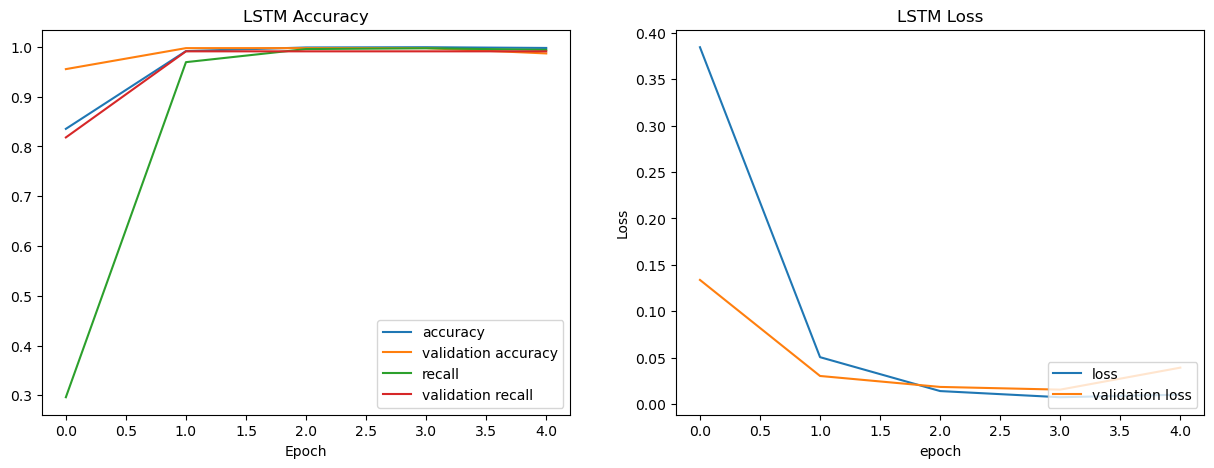

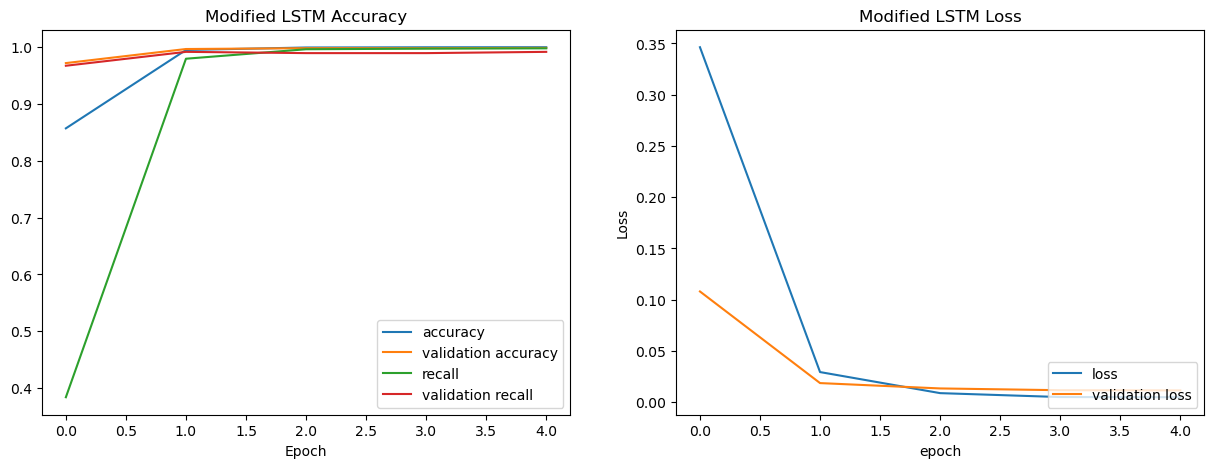

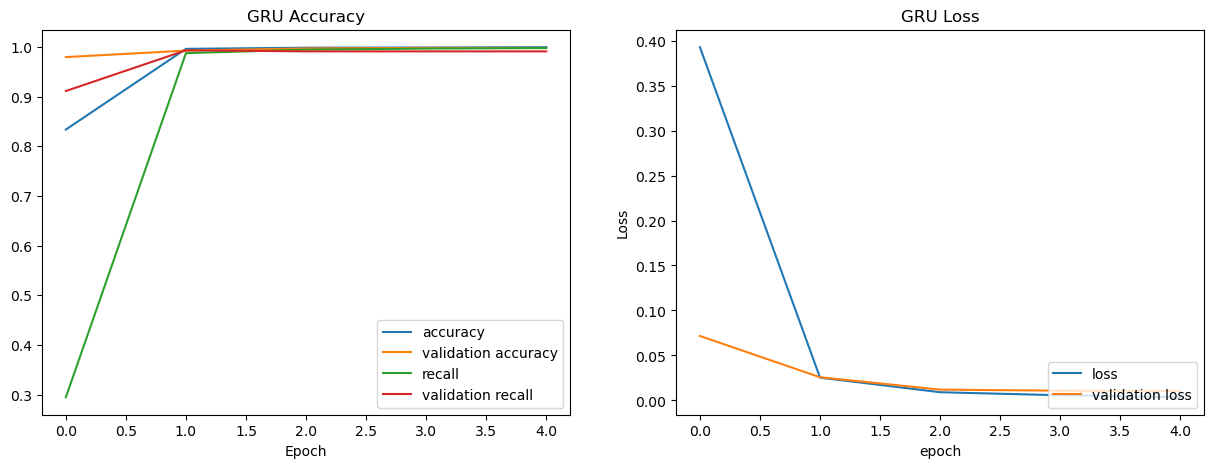

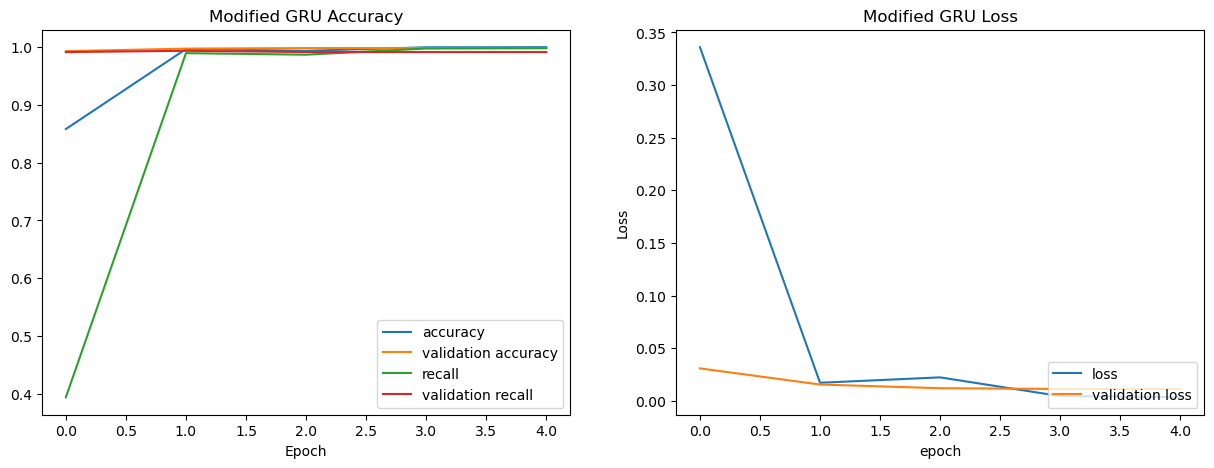

In [14]:
from matplotlib import pyplot as plt

def plotHistory(history, model_name, recall_num = None):
    recall_key = 'recall'
    if(recall_num):
        recall_key = recall_key+'_'+recall_num
    validation_key = 'val_'+recall_key
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history[recall_key])
    plt.plot(history.history[validation_key])
    plt.title(model_name+' Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'validation accuracy', 'recall', 'validation recall'], loc='lower right')
    
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model_name+' Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'validation loss'], loc='lower right')
    plt.show()
    
    
plotHistory(lstm_history, 'LSTM')
plotHistory(lstm_history2, 'Modified LSTM', '1')
plotHistory(gru_history, 'GRU','2')
plotHistory(gru_history2, 'Modified GRU', '3')

## 3. Exceptional Work 
(FREE POINTS WOOHOO +1)